# Aprendizaje por transferencia

El aprendizaje por transferencia (*transfer learning*) utiliza el conocimiento adquirido en una tarea para resolver una tarea relativamente similar. En el caso del aprendizaje profundo el conocimiento está representado en los pesos de una red neuronal, estos pesos se ajustan en una primera tarea y se reutilizan para resolver otra. En este caso se utiliza aprendizaje por transferencia para realizar la clasificación de imágenes de rayos x del pecho en las categorías de Neumonía o no-neumonía. 

El notebook a continuación presenta la implementación del aprendizaje utilizando la red entrenada VGG en la clasificación de las imágenes contenidas en el NIH-chest ray dataset. 

In [3]:
# Paquetes requeridos

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain

import tensorflow
import keras
import sklearn
import sklearn.model_selection as skl
from sklearn.metrics import f1_score
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


In [4]:
from platform import python_version

print('python:', python_version())
print('tensowflow:', tensorflow.__version__)
print('keras: ', keras.__version__)

python: 3.7.6
tensowflow: 2.1.0
keras:  2.3.1


# Preprocesamiento de los Datos

## Lectura y adaptación

In [5]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)


Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
92439,00023078_003.png,Atelectasis|Nodule|Pneumothorax,3,23078,64,M,PA,2992,2991,0.143,0.143,NaN,/data/images_010/images/00023078_003.png
92154,00023012_001.png,No Finding,1,23012,49,M,PA,2750,2468,0.143,0.143,NaN,/data/images_010/images/00023012_001.png
33343,00008745_002.png,Infiltration,2,8745,45,M,AP,2500,2048,0.168,0.168,NaN,/data/images_004/images/00008745_002.png


In [6]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
47057,00011997_009.png,No Finding,9,11997,45,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
100795,00026769_009.png,Atelectasis|Nodule,9,26769,58,M,PA,1940,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
45633,00011702_007.png,Infiltration,7,11702,25,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['pneumonia_class'] = all_xray_df['Finding Labels'].map(lambda finding: 'True' if 'Pneumonia' in finding else 'False')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
21089,00005638_002.png,Mass,2,5638,59,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,False
89355,00022185_016.png,Atelectasis|Effusion|Infiltration,16,22185,77,M,AP,3056,2544,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,False
48211,00012222_001.png,No Finding,1,12222,56,F,PA,2602,2477,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False


## División del conjunto de datos

Dividir el conjunto de datos nos permite establecer una parte que servirá como datos de entrenamiento y otro conjunto llamado validación que permitirá medir que tan bien está generalizando el algoritmo de aprendizaje. El conjunto de validación no es visto por el algoritmo de aprendizaje. 

Para darnos una idea de lo que tenemos que hacer, primero recuperaremos la distribución de las clases obtenida en el análisis exploratorio.

![](output_20_0.png)

Podemos observar que tenemos diversas clases y éstas están desbalanceadas. Como el caso de estudio es neumonía, todas las clases restantes son consideradas no-neumonía. Por lo tanto mi estrategia para contrarestar el desbalance es submuestrear la case mayoritaria e igualar el número de ejemplos de la clase minoritaria. Una vez igualadas las clases haré la división en conjunto de entrenamiento y validación.



In [8]:
# Obtener clase minoritaria
minority_class = all_xray_df[all_xray_df.Pneumonia == 1]
print('Minority class examples: ', minority_class.shape[0])
#minority_class.sample(5)

# Obtener la clase mayoritaria
majority_class = all_xray_df[all_xray_df.Pneumonia != 1]
#majority_class.sample(5)

# Remuestrear la clase mayoritaria
random_seed = 54
resampled_class = sklearn.utils.resample(majority_class, replace = False, n_samples = minority_class.shape[0], random_state = random_seed, )
print('Resampled class examples: ', resampled_class.shape[0])
# I am going to split into 80 and 20

# Fusionar ambas clases
df_balanced = pd.concat([minority_class, resampled_class])

train_df, valid_df = skl.train_test_split(df_balanced, test_size = 0.2, stratify = df_balanced['Pneumonia'])
IMG_SIZE = (224, 224)

Minority class examples:  1431
Resampled class examples:  1431


## Aumentación de datos

In [9]:
#Hyper-parameters
batch_size = 200

In [10]:
## Data augmentation
# so far I will use the standard keras generator

# Data Generator for training includes random modifications to the images
my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)

# Data generator for validation does not include random modifications
my_idg_no_augmentation = ImageDataGenerator(rescale=1. / 255.0)

train_gen = my_idg.flow_from_dataframe(  dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = batch_size
                                         )

val_gen = my_idg_no_augmentation.flow_from_dataframe(dataframe=valid_df, 
                                  directory=None, 
                                  x_col = 'path',
                                  y_col = 'pneumonia_class',
                                  class_mode = 'binary',
                                  target_size = IMG_SIZE, 
                                  batch_size = batch_size
                                  )

Found 2289 validated image filenames belonging to 2 classes.
Found 573 validated image filenames belonging to 2 classes.


In [11]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()
print(valY)

[0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.
 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1.
 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0.
 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1.
 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 0. 1.]


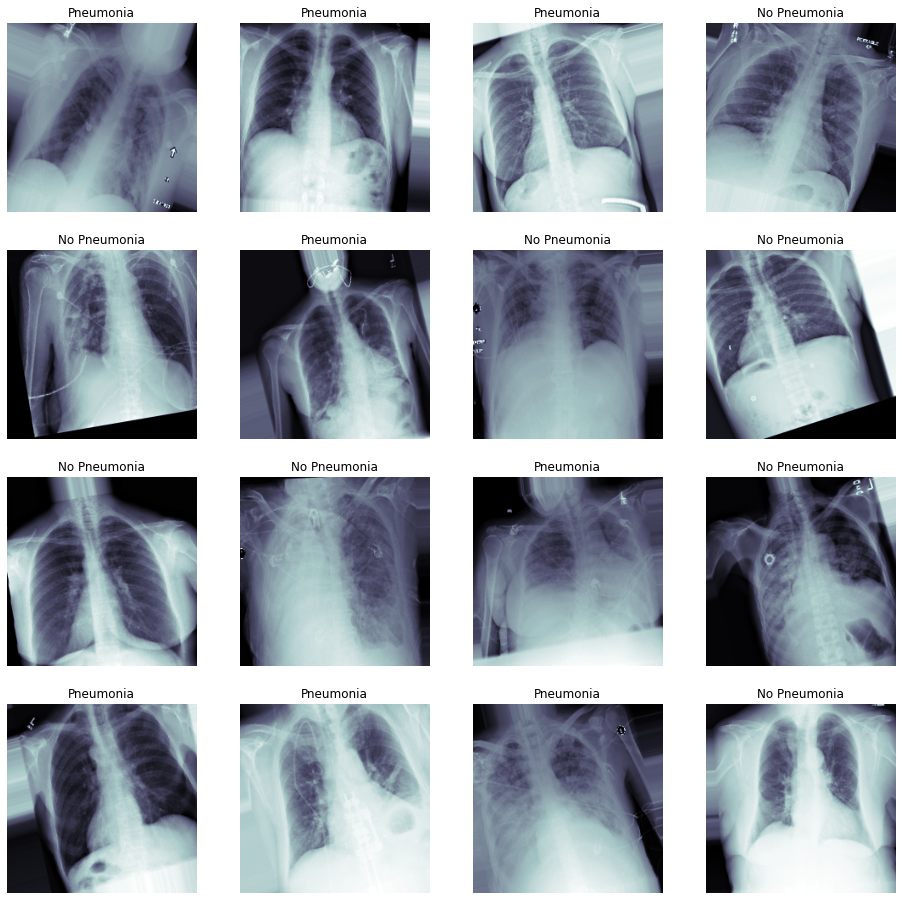

In [12]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

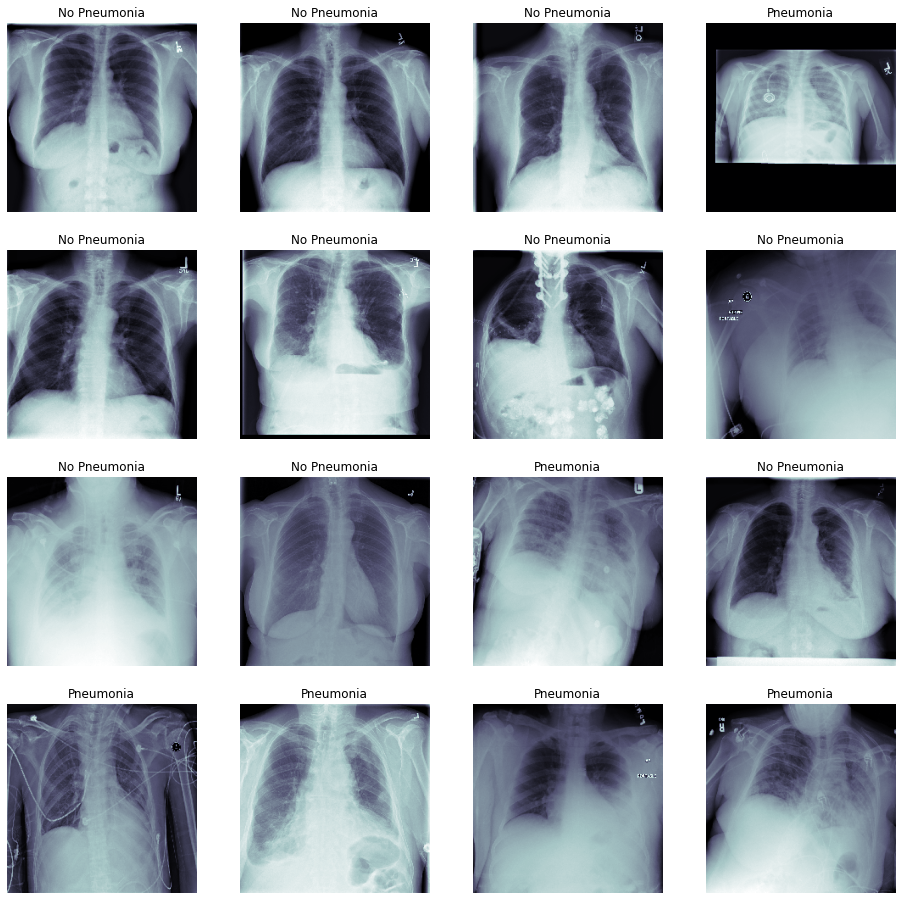

In [13]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(val_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

# Construcción del modelo

Se utilizará la arquitectura de VGG16 preentrenada con el conjunto de datos de imagenet.

- Instanciar el modelo
- Descargar y establecer los pesos
- Eliminar la capa completamente conectada y mantener las capas convolucionales con sus respectivos pesos
- Agregar cuatro capas completamente conectadas con pesos aleatorios

In [14]:
model = VGG16(include_top = True, weights='imagenet')
model.summary()

553467904/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [15]:
## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

## Now, choose which layers of VGG16 we actually want to fine-tune (if any)
## Here, we'll freeze all but the last convolutional layer
for layer in vgg_model.layers[0:17]:
    layer.trainable = False
    
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [16]:
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(vgg_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(512, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(256, activation='relu'))

# Add a dense (aka. fully-connected) layer.
# Change the activation function to sigmoid 
# so output of the last layer is in the range of [0,1] 
new_model.add(Dense(1, activation='sigmoid'))

## Establecer optimizador 

In [17]:
## Set our optimizer, loss function, and learning rate
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [18]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [19]:
## Just run a single epoch to see how it does:
new_model.fit_generator(train_gen, 
                                  validation_data = (valX, valY), 
                                  epochs = 1)

Epoch 1/1
12/12 [==============================] - 66s 6s/step - loss: 0.8074 - binary_accuracy: 0.5033 - val_loss: 0.7672 - val_binary_accuracy: 0.4700


In [20]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping( monitor= 'val_loss', 
                       mode= 'min', 
                       patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [21]:
epochs = 50

In [20]:
history = new_model.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = epochs, 
                           callbacks = callbacks_list)

Epoch 1/50
12/12 [==============================] - 60s 5s/step - loss: 0.7262 - binary_accuracy: 0.5356 - val_loss: 0.6861 - val_binary_accuracy: 0.5700

Epoch 00001: val_loss improved from inf to 0.68610, saving model to xray_class_my_model.best.hdf5
Epoch 2/50
12/12 [==============================] - 58s 5s/step - loss: 0.7050 - binary_accuracy: 0.5299 - val_loss: 0.6811 - val_binary_accuracy: 0.5750

Epoch 00002: val_loss improved from 0.68610 to 0.68112, saving model to xray_class_my_model.best.hdf5
Epoch 3/50
12/12 [==============================] - 60s 5s/step - loss: 0.7143 - binary_accuracy: 0.5321 - val_loss: 0.6751 - val_binary_accuracy: 0.5500

Epoch 00003: val_loss improved from 0.68112 to 0.67512, saving model to xray_class_my_model.best.hdf5
Epoch 4/50
12/12 [==============================] - 57s 5s/step - loss: 0.6956 - binary_accuracy: 0.5540 - val_loss: 0.6774 - val_binary_accuracy: 0.5800

Epoch 00004: val_loss did not improve from 0.67512
Epoch 5/50
12/12 [=========

### Plotting the results

In [36]:
#Also consider plotting the history of your model training:

# Fucntion from https://github.com/datasolver/
def plot_history(history):        
    x_values = np.arange(0, len(history.history["loss"]))
    metrics = ["loss", "val_loss", "binary_accuracy", "val_binary_accuracy"]
    labels = ["train_loss", "val_loss", "train_acc", "val_acc"]
    markers = ['k-', 'r-', 'b-', 'g-']
    plt.figure(figsize=(7,7))
    for ind, metric in enumerate(metrics):
        plt.plot(x_values, history.history[metric], markers[ind] , label=labels[ind])
    plt.title("Training & Validation Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="best")    
    return

def plot_f1s(F1s):
    plt.figure(figsize=(5,5))
    plt.plot(F1s)
    plt.title('F1 score')
    plt.xlabel("Threshold")
    plt.ylabel("F1")
    plt.show()
    return


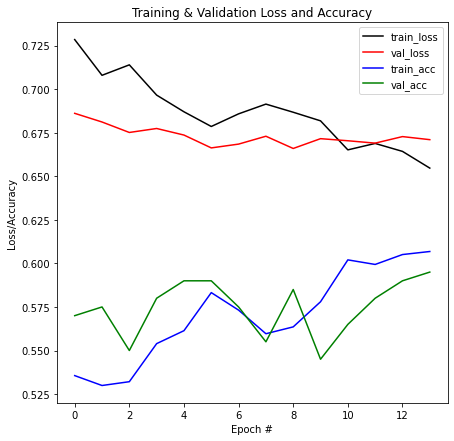

In [24]:
plot_history(history)

In [22]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
new_model.load_weights(weight_path)
pred_Y = new_model.predict(valX, batch_size = 32, verbose = True)
#print(pred_Y)

200/200 [==============================] - 6s 31ms/step


In [23]:
from sklearn.metrics import roc_curve, precision_recall_curve
#y_pred_keras = keras_model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(valY, pred_Y)
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

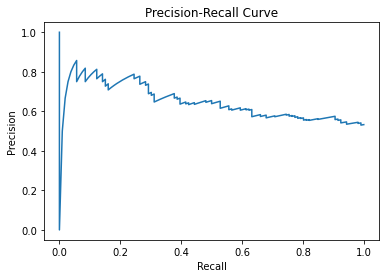

In [24]:
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

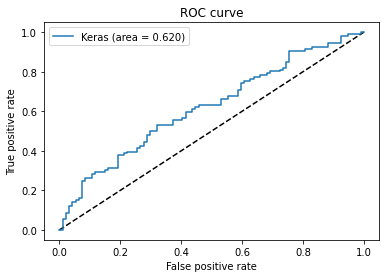

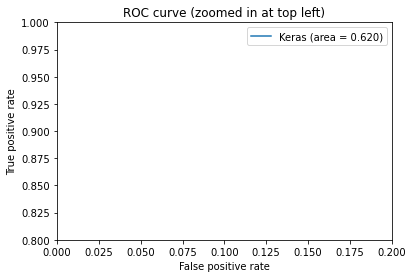

In [25]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()


### Metric optimization

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [26]:
def sensibility(tp, fn):
    return tp / (tp + fn)

def specificity(tn, fp):
    return tn / (tn + fp)

def getSensAndSpec(threshold, predictions):
    over_threshold = predictions >= threshold
    over_threshold = [[1] if result[0] else [0] for result in over_threshold]
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(valY, over_threshold).ravel()
    return [sensibility(tp, fn), specificity(tn, fp)]

def getF1(threshold, predictions):
    over_threshold = predictions >= threshold
    over_threshold = [[1] if result[0] else [0] for result in over_threshold]
    return f1_score(valY, over_threshold, average='macro')

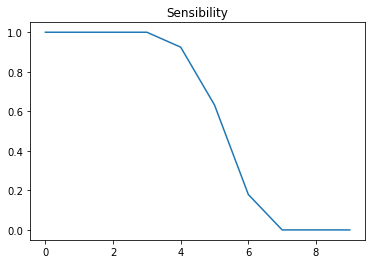

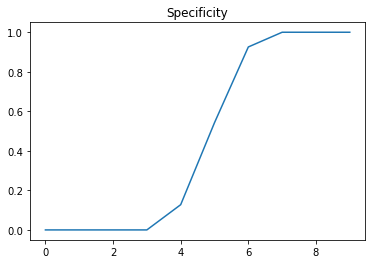

In [27]:
# Optimization
Threshold = np.arange(0,1,0.1)

SensSpec = np.array([getSensAndSpec(thres, pred_Y) for thres in Threshold])

plt.plot(SensSpec[:,0])
plt.title('Sensibility')
plt.show()

plt.plot(SensSpec[:,1])
plt.title('Specificity')
plt.show()

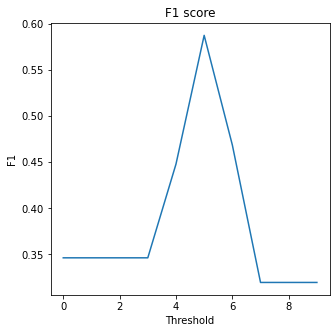

In [38]:
# Optimization
F1s = np.array([getF1(thres, pred_Y) for thres in Threshold])
plot_f1s(F1s)

### Performance of the selected threshold

In [39]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# I am selecting sensibility as my target metric since I want to reduce false negatives. 
# Even though the best F1 score is obtained when the threshold is equal to 0.5
# I selects threshold 0.4 because it shows a better sensibility
YOUR_THRESHOLD=0.4

over_threshold = pred_Y >= YOUR_THRESHOLD
#print(over_threshold[:10])
over_threshold = [[1] if result[0] else [0] for result in over_threshold]
#print(over_threshold[:10])

tn, fp, fn, tp = sklearn.metrics.confusion_matrix(valY, over_threshold).ravel()

print('Sensibility:', sensibility(tp, fn))
print('Specificity:', specificity(tn, fp))



Sensibility: 0.9245283018867925
Specificity: 0.1276595744680851


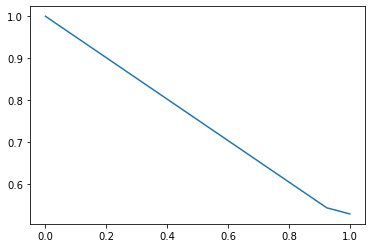

In [31]:
precision, recall, thresholds = precision_recall_curve(valY, over_threshold)
plt.plot(recall, precision)
plt.show()

In [40]:
f1_score(valY, over_threshold, average='macro')

0.4479205005520795

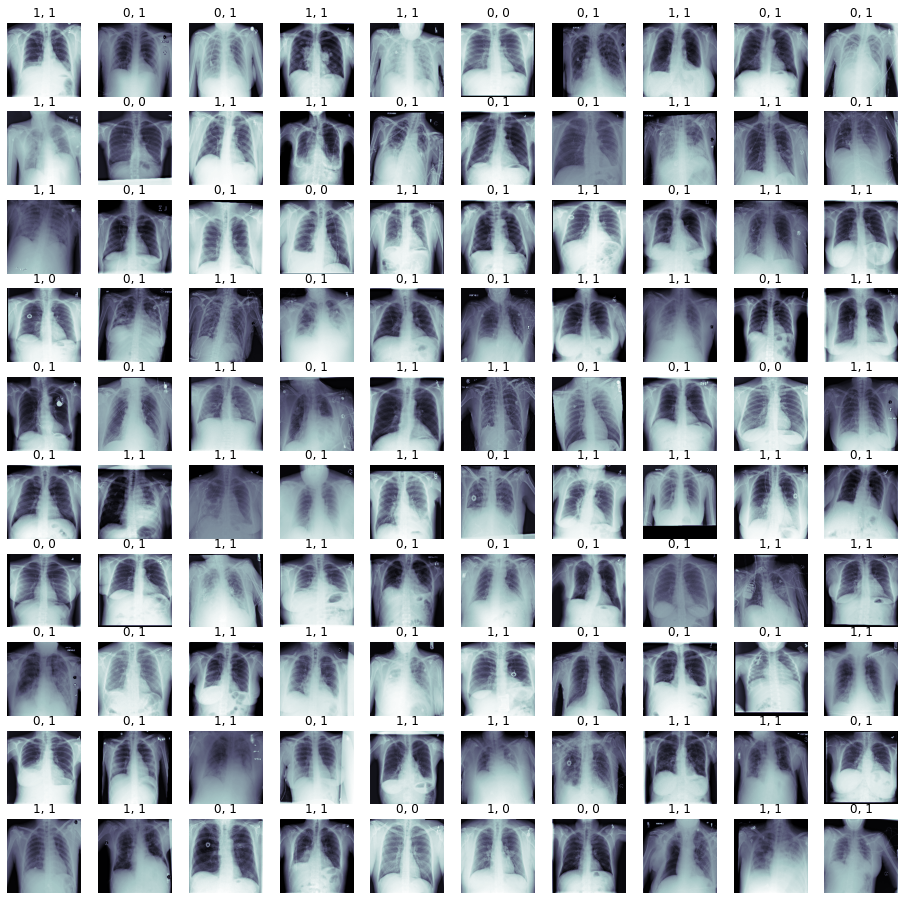

In [76]:
## Let's look at some examples of true vs. predicted with our best model: 

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    #valY
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1.: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [77]:
## Just save model architecture to a .json:

model_json = new_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)